In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
file_path = 'dataset/'

train_df = pd.read_csv(file_path + 'train.csv')

experiment_df_list = []
n_experiment = 10

for i in range(1, n_experiment + 1):
    if i < 10:
        experiment_df_list.append(pd.read_csv(file_path + 'experiment_0' + str(i) + '.csv'))
    else:
        experiment_df_list.append(pd.read_csv(file_path + 'experiment_' + str(i) + '.csv'))

for i in range(len(experiment_df_list)):
    print("Experiment {} total length: {}".format(i + 1, len(experiment_df_list[i])))

Experiment 1 total length: 1055
Experiment 2 total length: 1668
Experiment 3 total length: 1521
Experiment 4 total length: 532
Experiment 5 total length: 462
Experiment 6 total length: 1296
Experiment 7 total length: 565
Experiment 8 total length: 605
Experiment 9 total length: 740
Experiment 10 total length: 1301


In [3]:
worn_df = pd.DataFrame()
unworn_df = pd.DataFrame()

for i in range(len(experiment_df_list)):
    temp_df = experiment_df_list[i].iloc[:, :43]

    for col in experiment_df_list[i].columns:
        if all(experiment_df_list[i][col] == 0.0):
            temp_df = temp_df.drop(labels=col, axis = 1)

    if train_df.iloc[i, 4] == 'worn':
        print("Experiment {} -> worn".format(i + 1))
        temp_df['worn'] = 1
        worn_df = pd.concat([worn_df, temp_df], axis = 0)

    elif train_df.iloc[i, 4] == 'unworn':
        print("Experiment {} -> unworn".format(i + 1))
        temp_df['worn'] = 0
        unworn_df = pd.concat([unworn_df, temp_df], axis = 0)

print("Worn experiment total length: {}".format(len(worn_df)))
print("Unworn experiment total length: {}".format(len(unworn_df)))

Experiment 1 -> unworn
Experiment 2 -> unworn
Experiment 3 -> unworn
Experiment 4 -> unworn
Experiment 5 -> unworn
Experiment 6 -> worn
Experiment 7 -> worn
Experiment 8 -> worn
Experiment 9 -> worn
Experiment 10 -> worn
Worn experiment total length: 4507
Unworn experiment total length: 5238


In [4]:
def calculate_outlier_percentage(df):
    outlier_percentages = {}
    
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            # 사분위수 계산
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            
            # 이상치 기준 설정
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # 이상치 판별
            outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
            outlier_percentage = (outliers.sum() / len(df)) * 100
            
            outlier_percentages[column] = outlier_percentage
            
    return outlier_percentages

In [5]:
### worn ###

# CNC 공구 마모 여부에 따른 데이터에 대해 각 column 별로 분포를 확인할 수 있는 시각화 자료 1
# 공구 마모 o (i.e., worn_df)
'''
데이터 분포도를 통해 정규 분포를 따르는 데이터인지 편향되어 있는 데이터 인지 여러 개의 군집으로 나뉘어져 있는지 확인할 수 있다
이 외에도 이상치 탐지 및 데이터 간의 상관관계도 분석이 가능하다
이를 기반으로 데이터가 선형적으로 분포한다면 선형 회귀 모델이 효과적일 수 있고 비선형 적으로 분포되어 있다면 비선형 모델이 학습에
적합할 수 있다. 또한 데이터 간의 스케일이 크게 다른 경우 정규화할 지를 판단할 수 있다
또한 예를 들어 각 피쳐에서 값의 범위가 너무 넓게 분포되어 있다면 특정 알고리즘에 대해서 학습이 어려울 수 있다는 걸 판단할 수 있다
'''

'''
이상치란 데이터에서 다른 관찰값들과 크게 다른 값을 가진 관찰 결과를 말한다 -> 스케일링을 통해 해결 가능
사분위수를 통해 데이터의 중앙 집중 경향을 판단할 수 있고 사분위의 범위를 통해 분산 정도와 이상치를 탐지할 수 있음
'''


display(worn_df.describe())
'''
# 컬럼별 이상치 비율 계산
worn_df_outlier_percentages = calculate_outlier_percentage(worn_df)

plt.bar(worn_df_outlier_percentages.keys(), worn_df_outlier_percentages.values())
plt.title('Outlier Percentage by Column')
plt.xlabel('Columns')
plt.ylabel('Outlier Percentage (%)')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(100, 500))

# 컬럼별 분포도
for i, column in enumerate(worn_df.columns, 1):
    plt.subplot(len(worn_df.columns), 5, i)
    plt.hist(worn_df[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.show()
'''

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,worn
count,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,...,4507.000000,4507.000000,4507.000000,4.507000e+03,4507.000000,4.507000e+03,4507.000000,4507.000000,4507.000000,4507.0
mean,160.362769,-0.478782,2.822032,160.355447,-0.486692,-1.253606,-0.761420,0.068688,325.591302,10.260260,...,-0.364323,-280.156734,31.259263,5.990681e-01,12.785799,5.640905e-01,322.013535,69.537149,0.106612,1.0
std,21.406512,8.631671,135.625677,21.404691,8.644390,118.569903,4.472576,0.043482,1.651183,11.065234,...,32.079070,1112.665944,26.197978,7.717587e+00,11.504268,4.971500e-01,4.773572,58.242709,0.091656,0.0
min,141.000000,-20.300000,-1280.000000,141.000000,-20.000000,-1000.000000,-23.200000,0.014500,320.000000,0.076300,...,-150.000000,-2150.000000,0.000000,-9.540000e-07,-8.280000,2.710000e-19,300.000000,0.000000,-0.002800,1.0
25%,142.000000,-0.225000,-31.300000,142.000000,0.000000,0.000000,-3.815000,0.031700,324.000000,1.910000,...,-12.250000,-1000.000000,0.000000,0.000000e+00,0.213000,2.790000e-19,318.000000,0.000000,0.000000,1.0
50%,152.000000,0.000000,0.000000,152.000000,0.000000,0.000000,-1.100000,0.056700,325.000000,4.620000,...,0.000000,-332.000000,53.300000,0.000000e+00,17.200000,8.220000e-01,321.000000,116.000000,0.156000,1.0
75%,162.000000,0.125000,31.300000,162.000000,0.000000,0.000000,1.700000,0.099800,327.000000,14.800000,...,9.840000,383.000000,53.300000,0.000000e+00,22.100000,9.570000e-01,327.000000,119.000000,0.183000,1.0
max,198.000000,50.300000,1440.000000,198.000000,50.000000,1000.000000,24.400000,0.365000,329.000000,75.400000,...,128.000000,2150.000000,53.300000,1.000000e+02,70.100000,3.040000e+00,328.000000,129.000000,0.533000,1.0


"\n# 컬럼별 이상치 비율 계산\nworn_df_outlier_percentages = calculate_outlier_percentage(worn_df)\n\nplt.bar(worn_df_outlier_percentages.keys(), worn_df_outlier_percentages.values())\nplt.title('Outlier Percentage by Column')\nplt.xlabel('Columns')\nplt.ylabel('Outlier Percentage (%)')\nplt.xticks(rotation=90)\nplt.show()\n\nplt.figure(figsize=(100, 500))\n\n# 컬럼별 분포도\nfor i, column in enumerate(worn_df.columns, 1):\n    plt.subplot(len(worn_df.columns), 5, i)\n    plt.hist(worn_df[column])\n    plt.title(f'Histogram of {column}')\n    plt.xlabel('Value')\n    plt.ylabel('Frequency')\nplt.show()\n"

In [6]:
### unworn ###

# CNC 공구 마모 여부에 따른 데이터에 대해 각 column 별로 분포를 확인할 수 있는 시각화 자료 2
# 공구 마모 x (i.e., unworn_df)

display(unworn_df.describe())
'''
# 컬럼별 이상치 비율 계산
unworn_df_outlier_percentages = calculate_outlier_percentage(unworn_df)

plt.bar(unworn_df_outlier_percentages.keys(), unworn_df_outlier_percentages.values())
plt.title('Outlier Percentage by Column')
plt.xlabel('Columns')
plt.ylabel('Outlier Percentage (%)')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(100, 500))

# 컬럼별 분포도
for i, column in enumerate(unworn_df.columns, 1):
    plt.subplot(len(unworn_df.columns), 5, i)
    plt.hist(unworn_df[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.show()
'''

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,worn
count,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5.238000e+03,5238.000000,5238.000000,...,5238.000000,5238.000000,5238.000000,5.238000e+03,5238.000000,5.238000e+03,5238.000000,5238.000000,5238.000000,5238.0
mean,170.928026,-0.322168,2.803666,170.931271,-0.311994,0.894893,-0.433103,5.274296e-02,326.835433,7.278585,...,0.112664,-63.458627,26.348435,5.345552e-01,10.513985,4.660950e-01,324.103666,58.418737,0.088200,0.0
std,24.008447,6.612358,104.130858,24.013193,6.631079,86.501002,3.988959,4.674771e-02,1.495467,9.469569,...,26.053652,1105.785140,26.605691,7.292456e+00,11.554730,4.904677e-01,5.034589,58.952649,0.090886,0.0
min,141.000000,-20.400000,-1190.000000,141.000000,-20.000000,-1000.000000,-23.400000,2.780000e-19,320.000000,0.000000,...,-106.000000,-2150.000000,0.000000,-9.540000e-07,-6.270000,0.000000e+00,290.000000,0.000000,-0.002010,0.0
25%,149.000000,-0.125000,-12.500000,149.000000,0.000000,0.000000,-3.060000,1.800000e-02,326.000000,0.691250,...,-1.310000,-1160.000000,0.000000,0.000000e+00,0.054000,2.750000e-19,320.000000,0.000000,0.000000,0.0
50%,161.000000,0.000000,0.000000,161.000000,0.000000,0.000000,-0.321000,4.360000e-02,326.000000,3.200000,...,0.000000,206.000000,0.000000,0.000000e+00,1.895000,2.780000e-19,323.000000,0.000000,0.000445,0.0
75%,198.000000,0.025000,12.500000,198.000000,0.000000,0.000000,1.120000,8.940000e-02,328.000000,12.900000,...,1.560000,905.000000,53.300000,0.000000e+00,21.200000,9.260000e-01,329.000000,118.000000,0.177000,0.0
max,198.000000,50.700000,1440.000000,198.000000,50.000000,1000.000000,25.800000,3.800000e-01,330.000000,73.800000,...,150.000000,2150.000000,53.300000,1.000000e+02,75.400000,3.150000e+00,332.000000,130.000000,0.568000,0.0


"\n# 컬럼별 이상치 비율 계산\nunworn_df_outlier_percentages = calculate_outlier_percentage(unworn_df)\n\nplt.bar(unworn_df_outlier_percentages.keys(), unworn_df_outlier_percentages.values())\nplt.title('Outlier Percentage by Column')\nplt.xlabel('Columns')\nplt.ylabel('Outlier Percentage (%)')\nplt.xticks(rotation=90)\nplt.show()\n\nplt.figure(figsize=(100, 500))\n\n# 컬럼별 분포도\nfor i, column in enumerate(unworn_df.columns, 1):\n    plt.subplot(len(unworn_df.columns), 5, i)\n    plt.hist(unworn_df[column])\n    plt.title(f'Histogram of {column}')\n    plt.xlabel('Value')\n    plt.ylabel('Frequency')\nplt.show()\n"

In [7]:
# 향후 텐서 변환 및 모델 네크워크를 device를 기반으로 하여 생성

print ("PyTorch version:[%s]."%(torch.__version__))

if torch.cuda.is_available():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)

PyTorch version:[1.12.1].
cuda:0


In [8]:
# worn_df 및 unworn_df를 기반으로 한 학습 데이터 생성
# 데이터 배치 처리, 스케일링, 셔플링 등을 포함한 데이터 전처리 과정

min_max_scaler = MinMaxScaler(feature_range=(0,1))
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

# 중앙값이 0, IQR이 1이 되게 스케일링
robust_scaled_worn = robust_scaler.fit_transform(worn_df)
robust_scaled_unworn = robust_scaler.fit_transform(unworn_df)

# 평균이 0, 표준편차가 1인 분포로 표준화
#standard_scaled_worn = standard_scaler.fit_transform(worn_df)
#standard_scaled_unworn = standard_scaler.fit_transform(unworn_df)

# 0과 1사이의 값으로 정규화
#min_max_scaled_worn = min_max_scaler.fit_transform(worn_df)
#min_max_scaled_unworn = min_max_scaler.fit_transform(unworn_df)

# 스케일링된 데이터프레임
scaled_worn_df = pd.DataFrame(robust_scaled_worn, columns=worn_df.columns)
scaled_unworn_df = pd.DataFrame(robust_scaled_unworn, columns=unworn_df.columns)

display(scaled_worn_df.describe())
display(scaled_unworn_df.describe())

# 스케일링된 텐서
worn_tensor = torch.tensor(robust_scaled_worn, dtype=torch.float32)
unworn_tensor = torch.tensor(robust_scaled_unworn, dtype=torch.float32)

# 레이블 값 설정
worn_tensor[:, -1] = 1
unworn_tensor[:, -1] = 0

# 열 방향으로 결합
train_tensor = torch.cat((worn_tensor, unworn_tensor), dim=0)

# 전체 데이터와 전체 레이블 생성
data = train_tensor[:, :-1]
target = train_tensor[:, -1]

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,worn
count,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,...,4507.000000,4507.000000,4507.000000,4.507000e+03,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.0
mean,0.418138,-1.367948,0.045080,0.417772,-0.486692,-1.253606,0.061392,0.176030,0.197101,0.437569,...,-0.016493,0.037486,-0.413522,5.990681e-01,-0.201681,-0.269498,0.112615,-0.390444,-0.269879,0.0
std,1.070326,24.661917,2.166544,1.070235,8.644390,118.569903,0.810984,0.638496,0.550394,0.858436,...,1.452199,0.804531,0.491519,7.717587e+00,0.525621,0.519488,0.530397,0.489435,0.500851,0.0
min,-0.550000,-58.000000,-20.447284,-0.550000,-20.000000,-1000.000000,-4.007253,-0.619677,-1.666667,-0.352498,...,-6.790403,-1.314534,-1.000000,-9.540000e-07,-1.164161,-0.858934,-2.333333,-0.974790,-0.867760,0.0
25%,-0.500000,-0.642857,-0.500000,-0.500000,0.000000,0.000000,-0.492294,-0.367107,-0.333333,-0.210240,...,-0.554550,-0.483008,-1.000000,0.000000e+00,-0.776123,-0.858934,-0.333333,-0.974790,-0.852459,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.500000,0.357143,0.500000,0.500000,0.000000,0.000000,0.507706,0.632893,0.666667,0.789760,...,0.445450,0.516992,0.000000,0.000000e+00,0.223877,0.141066,0.666667,0.025210,0.147541,0.0
max,2.300000,143.714286,23.003195,2.300000,50.000000,1000.000000,4.623753,4.527166,1.333333,5.491078,...,5.794477,1.794649,0.000000,1.000000e+02,2.416960,2.317659,0.777778,0.109244,2.060109,0.0


,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,worn
count,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,5238.000000,...,5238.000000,5238.000000,5238.000000,5.238000e+03,5238.000000,5.238000e+03,5238.000000,5238.000000,5.238000e+03,5238.0
mean,0.202613,-2.147785,0.112147,0.202679,-0.311994,0.894893,-0.026819,0.128053,0.417717,0.334071,...,0.039256,-0.130488,0.494342,5.345552e-01,0.407594,5.033423e-01,0.122630,0.495074,4.957934e-01,0.0
std,0.489968,44.082384,4.165234,0.490065,6.631079,86.501002,0.954296,0.654730,0.747734,0.775638,...,9.077927,0.535489,0.499169,7.292456e+00,0.546426,5.296628e-01,0.559399,0.499599,5.134779e-01,0.0
min,-0.408163,-136.000000,-47.600000,-0.408163,-20.000000,-1000.000000,-5.521292,-0.610644,-3.000000,-0.262107,...,-36.933798,-1.140920,0.000000,-9.540000e-07,-0.386125,-3.002160e-19,-3.666667,0.000000,-1.387006e-02,0.0
25%,-0.244898,-0.833333,-0.500000,-0.244898,0.000000,0.000000,-0.655263,-0.358543,0.000000,-0.205488,...,-0.456446,-0.661501,0.000000,0.000000e+00,-0.087061,-3.239741e-21,-0.333333,0.000000,-2.514124e-03,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,1.355253e-19,0.0
75%,0.755102,0.166667,0.500000,0.755102,0.000000,0.000000,0.344737,0.641457,1.000000,0.794512,...,0.543554,0.338499,1.000000,0.000000e+00,0.912939,1.000000e+00,0.666667,1.000000,9.974859e-01,0.0
max,0.755102,338.000000,57.600000,0.755102,50.000000,1000.000000,6.249043,4.711485,2.000000,5.782738,...,52.264808,0.941404,1.000000,1.000000e+02,3.476071,3.401728e+00,1.000000,1.101695,3.206525e+00,0.0


In [9]:
### scaled_worn ###
'''
# 컬럼별 이상치 비율 계산
scaled_worn_df_outlier_percentages = calculate_outlier_percentage(scaled_worn_df)

plt.bar(scaled_worn_df_outlier_percentages.keys(), scaled_worn_df_outlier_percentages.values())
plt.title('Outlier Percentage by Column')
plt.xlabel('Columns')
plt.ylabel('Outlier Percentage (%)')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(100, 500))

# 컬럼별 분포도
for i, column in enumerate(scaled_worn_df.columns, 1):
    plt.subplot(len(scaled_worn_df.columns), 5, i)
    plt.hist(scaled_worn_df[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.show()
'''

"\n# 컬럼별 이상치 비율 계산\nscaled_worn_df_outlier_percentages = calculate_outlier_percentage(scaled_worn_df)\n\nplt.bar(scaled_worn_df_outlier_percentages.keys(), scaled_worn_df_outlier_percentages.values())\nplt.title('Outlier Percentage by Column')\nplt.xlabel('Columns')\nplt.ylabel('Outlier Percentage (%)')\nplt.xticks(rotation=90)\nplt.show()\n\nplt.figure(figsize=(100, 500))\n\n# 컬럼별 분포도\nfor i, column in enumerate(scaled_worn_df.columns, 1):\n    plt.subplot(len(scaled_worn_df.columns), 5, i)\n    plt.hist(scaled_worn_df[column])\n    plt.title(f'Histogram of {column}')\n    plt.xlabel('Value')\n    plt.ylabel('Frequency')\nplt.show()\n"

In [10]:
### scaled_unworn ###
'''
# 컬럼별 이상치 비율 계산
scaled_unworn_df_outlier_percentages = calculate_outlier_percentage(scaled_unworn_df)

plt.bar(scaled_unworn_df_outlier_percentages.keys(), scaled_unworn_df_outlier_percentages.values())
plt.title('Outlier Percentage by Column')
plt.xlabel('Columns')
plt.ylabel('Outlier Percentage (%)')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(100, 500))

# 컬럼별 분포도
for i, column in enumerate(scaled_unworn_df.columns, 1):
    plt.subplot(len(scaled_unworn_df.columns), 5, i)
    plt.hist(scaled_unworn_df[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.show()
'''

"\n# 컬럼별 이상치 비율 계산\nscaled_unworn_df_outlier_percentages = calculate_outlier_percentage(scaled_unworn_df)\n\nplt.bar(scaled_unworn_df_outlier_percentages.keys(), scaled_unworn_df_outlier_percentages.values())\nplt.title('Outlier Percentage by Column')\nplt.xlabel('Columns')\nplt.ylabel('Outlier Percentage (%)')\nplt.xticks(rotation=90)\nplt.show()\n\nplt.figure(figsize=(100, 500))\n\n# 컬럼별 분포도\nfor i, column in enumerate(scaled_unworn_df.columns, 1):\n    plt.subplot(len(scaled_unworn_df.columns), 5, i)\n    plt.hist(scaled_unworn_df[column])\n    plt.title(f'Histogram of {column}')\n    plt.xlabel('Value')\n    plt.ylabel('Frequency')\nplt.show()\n"

In [11]:
# pytorch 기반 LSTM 모델 구현

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob=0):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 계층 생성
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        if dropout_prob != 0:
            self.dropout = nn.Dropout(p=dropout_prob)
        self.affine = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.affine(out)
        out = self.sigmoid(out)
        return out

In [12]:
# 하이퍼파라미터
input_size = 39 # 입력 데이터의 벡터의 차원 수
hidden_size = 39 # 은닉 상태 벡터의 차원 수
num_layers = 1 # RNN계층의 수
activation_func = 'tanh' # RNN계층 활성화 함수
dropout_prob = 0.5 # 드롭아웃 비율
sequence_length = 100 # 시퀀스 길이
batch_size = 10 # 배치 수
lr = 0.01 # 학습률
weight_decay = 0 # 가중치 감소
num_epochs = 100 # 에폭 수
oprimizer_t = 'Adadelta'

In [13]:
# 시퀀스 및 타겟 생성
sequences = []
targets = []

# 슬라이딩 윈도우 기법
for i in range(len(data) - sequence_length):
    sequences.append(data[i:i + sequence_length])
    targets.append(target[i + sequence_length])

x_train = torch.stack(sequences)
t_train = torch.tensor(targets).view(-1, 1)

#데이터 셔플링
perm = torch.randperm(x_train.shape[0])
x_train = x_train[perm]
t_train = t_train[perm]

# 검증 데이터 생성
validation_rate = 0.2
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num].to(device)
t_val = t_train[:validation_num].to(device)
x_train = x_train[validation_num:].to(device)
t_train = t_train[validation_num:].to(device)

In [14]:
# 초기화
train_dataset = TensorDataset(x_train, t_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = LSTM(input_size, hidden_size, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adadelta(model.parameters(), lr=lr, weight_decay=weight_decay)

train_loss_list = []
train_ppl_list = []
train_acc_list = []
val_acc_list = []

# 초기 손실 및 정확도 계산
with torch.no_grad():
    model.train()
    y_train = model(x_train)
    y_train = torch.round(y_train)
    y_val = model(x_val)
    y_val = torch.round(y_val)
    
    loss = criterion(y_train, t_train)
    train_loss_list.append(loss.item())
    
    model.eval()
    train_acc = torch.sum(y_train == t_train) / float(x_train.shape[0])
    val_acc = torch.sum(y_val == t_val) / float(x_val.shape[0])
    train_acc_list.append(train_acc.item())
    val_acc_list.append(val_acc.item())

# 학습
for epoch in range(num_epochs):
    model.train()
    epoch_loss_list = []
    for x, t in train_dataloader:
        x = x.to(device)
        t = t.to(device)
        
        optimizer.zero_grad()
        
        # 예측(prediction)과 손실(loss) 계산
        y = model(x)
        loss = criterion(y, t)
        
        # 역전파
        loss.backward()
        optimizer.step()
        
        epoch_loss_list.append(loss.item())
    
    print(f'Epoch: [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
    train_loss_list.append(loss.item())
    
    #퍼플렉서티 계산
    avg_epoch_loss = sum(epoch_loss_list) / len(epoch_loss_list)
    ppl = torch.exp(torch.tensor(avg_epoch_loss))
    train_ppl_list.append(ppl.item())
        
    model.eval()
    with torch.no_grad():
        #정확도 계산
        y_train = model(x_train)
        y_train = torch.round(y_train)
        y_val = model(x_val)
        y_val = torch.round(y_val)
        train_acc = torch.sum(y_train == t_train) / float(x_train.shape[0])
        val_acc = torch.sum(y_val == t_val) / float(x_val.shape[0])
        train_acc_list.append(train_acc.item())
        val_acc_list.append(val_acc.item())

/home/coment-server3/anaconda3/envs/pytorch_1.11/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: [1/300], Loss: 0.7021
Epoch: [2/300], Loss: 0.7158
Epoch: [3/300], Loss: 0.6461
Epoch: [4/300], Loss: 0.6080
Epoch: [5/300], Loss: 0.6962
Epoch: [6/300], Loss: 0.6534
Epoch: [7/300], Loss: 0.6322
Epoch: [8/300], Loss: 0.6710
Epoch: [9/300], Loss: 0.6533
Epoch: [10/300], Loss: 0.5988
Epoch: [11/300], Loss: 0.5899
Epoch: [12/300], Loss: 0.5951
Epoch: [13/300], Loss: 0.6635
Epoch: [14/300], Loss: 0.7362
Epoch: [15/300], Loss: 0.6684
Epoch: [16/300], Loss: 0.6895
Epoch: [17/300], Loss: 0.6317
Epoch: [18/300], Loss: 0.6378
Epoch: [19/300], Loss: 0.6385
Epoch: [20/300], Loss: 0.6749
Epoch: [21/300], Loss: 0.6617
Epoch: [22/300], Loss: 0.5972
Epoch: [23/300], Loss: 0.6409
Epoch: [24/300], Loss: 0.5474
Epoch: [25/300], Loss: 0.5471
Epoch: [26/300], Loss: 0.5924
Epoch: [27/300], Loss: 0.4899
Epoch: [28/300], Loss: 0.5134
Epoch: [29/300], Loss: 0.5781
Epoch: [30/300], Loss: 0.4945
Epoch: [31/300], Loss: 0.5556
Epoch: [32/300], Loss: 0.4607
Epoch: [33/300], Loss: 0.5786
Epoch: [34/300], Lo

Epoch: [269/300], Loss: 0.0938
Epoch: [270/300], Loss: 0.1654
Epoch: [271/300], Loss: 0.0919
Epoch: [272/300], Loss: 0.0539
Epoch: [273/300], Loss: 0.1027
Epoch: [274/300], Loss: 0.1913
Epoch: [275/300], Loss: 0.0248
Epoch: [276/300], Loss: 0.0780
Epoch: [277/300], Loss: 0.3601
Epoch: [278/300], Loss: 0.0974
Epoch: [279/300], Loss: 0.3024
Epoch: [280/300], Loss: 0.0425
Epoch: [281/300], Loss: 0.1876
Epoch: [282/300], Loss: 0.0720
Epoch: [283/300], Loss: 0.1595
Epoch: [284/300], Loss: 0.1411
Epoch: [285/300], Loss: 0.0290
Epoch: [286/300], Loss: 0.2613
Epoch: [287/300], Loss: 0.0748
Epoch: [288/300], Loss: 0.0243
Epoch: [289/300], Loss: 0.2558
Epoch: [290/300], Loss: 0.0730
Epoch: [291/300], Loss: 0.0262
Epoch: [292/300], Loss: 0.1410
Epoch: [293/300], Loss: 0.0985
Epoch: [294/300], Loss: 0.1453
Epoch: [295/300], Loss: 0.0306
Epoch: [296/300], Loss: 0.0236
Epoch: [297/300], Loss: 0.0399
Epoch: [298/300], Loss: 0.0129
Epoch: [299/300], Loss: 0.1024
Epoch: [300/300], Loss: 0.1748


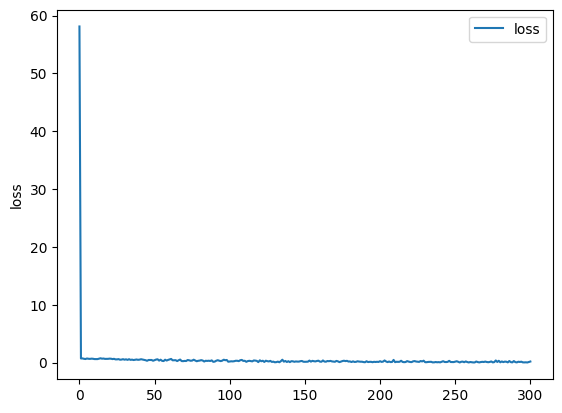

loss : [0.17482072114944458]


In [15]:
# 손실값 출력

x = torch.arange(0, num_epochs + 1, 1)

plt.plot(x, train_loss_list, label="loss")
plt.ylabel("loss")
plt.legend()
plt.show()

print("loss : " + str(train_loss_list[-1:]))

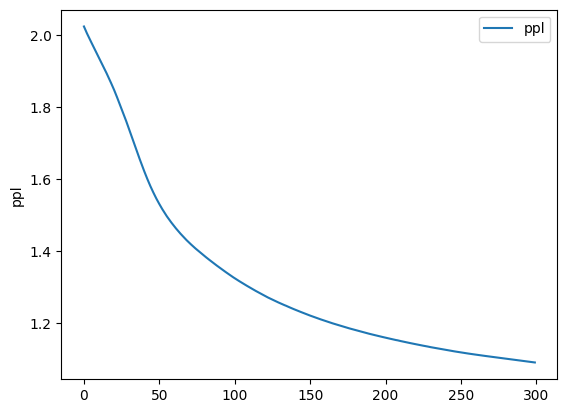

ppl : [1.0903512239456177]


In [16]:
# 퍼플렉서티 출력

x = torch.arange(0, num_epochs, 1)

plt.plot(x, train_ppl_list, label="ppl")
plt.ylabel("ppl")
plt.legend()
plt.show()

print("ppl : " + str(train_ppl_list[-1:]))

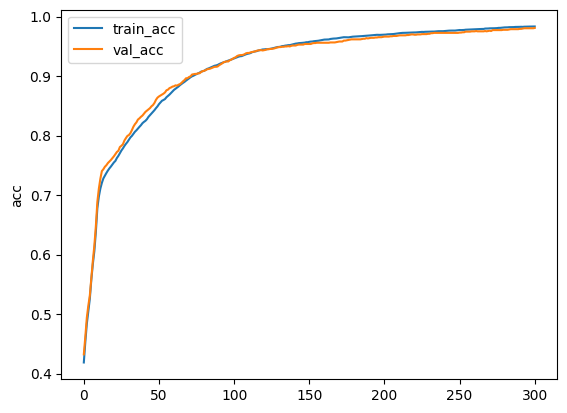

train_acc : [0.9832814931869507]
val_acc : [0.980819046497345]


In [17]:
# 정확도 출력

x = torch.arange(0, num_epochs + 1, 1)

plt.plot(x, train_acc_list, label="train_acc")
plt.plot(x, val_acc_list, label="val_acc")
plt.ylabel("acc")
plt.legend()
plt.show()

print("train_acc : " + str(train_acc_list[-1:]))
print("val_acc : " + str(val_acc_list[-1:]))